### Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [3]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cust

### Data Cleaning

In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df = df.dropna(subset=['CustomerID'])  # Remove missing customerID

In [7]:
df = df[(df['Quantity']>0)&(df['UnitPrice']>0)] # Remove negative quantities and prices

In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']  # Add TotalPrice column

In [9]:
df['CustomerID'] = df['CustomerID'].astype(int)  # Convert CustomerID to int

In [10]:
df.shape

(397884, 9)

In [11]:
df.isnull().sum() # Missing values after cleaning

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [12]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,397884.000000,397884,397884.000000,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453,22.397000
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,179.331775,NaN,22.097877,1713.141560,309.071041


In [13]:
df.duplicated().any()

np.True_

In [14]:
df = df.drop_duplicates() # Remove duplicates

### Exploratory Data Analysis

**1. Univariate Analysis**

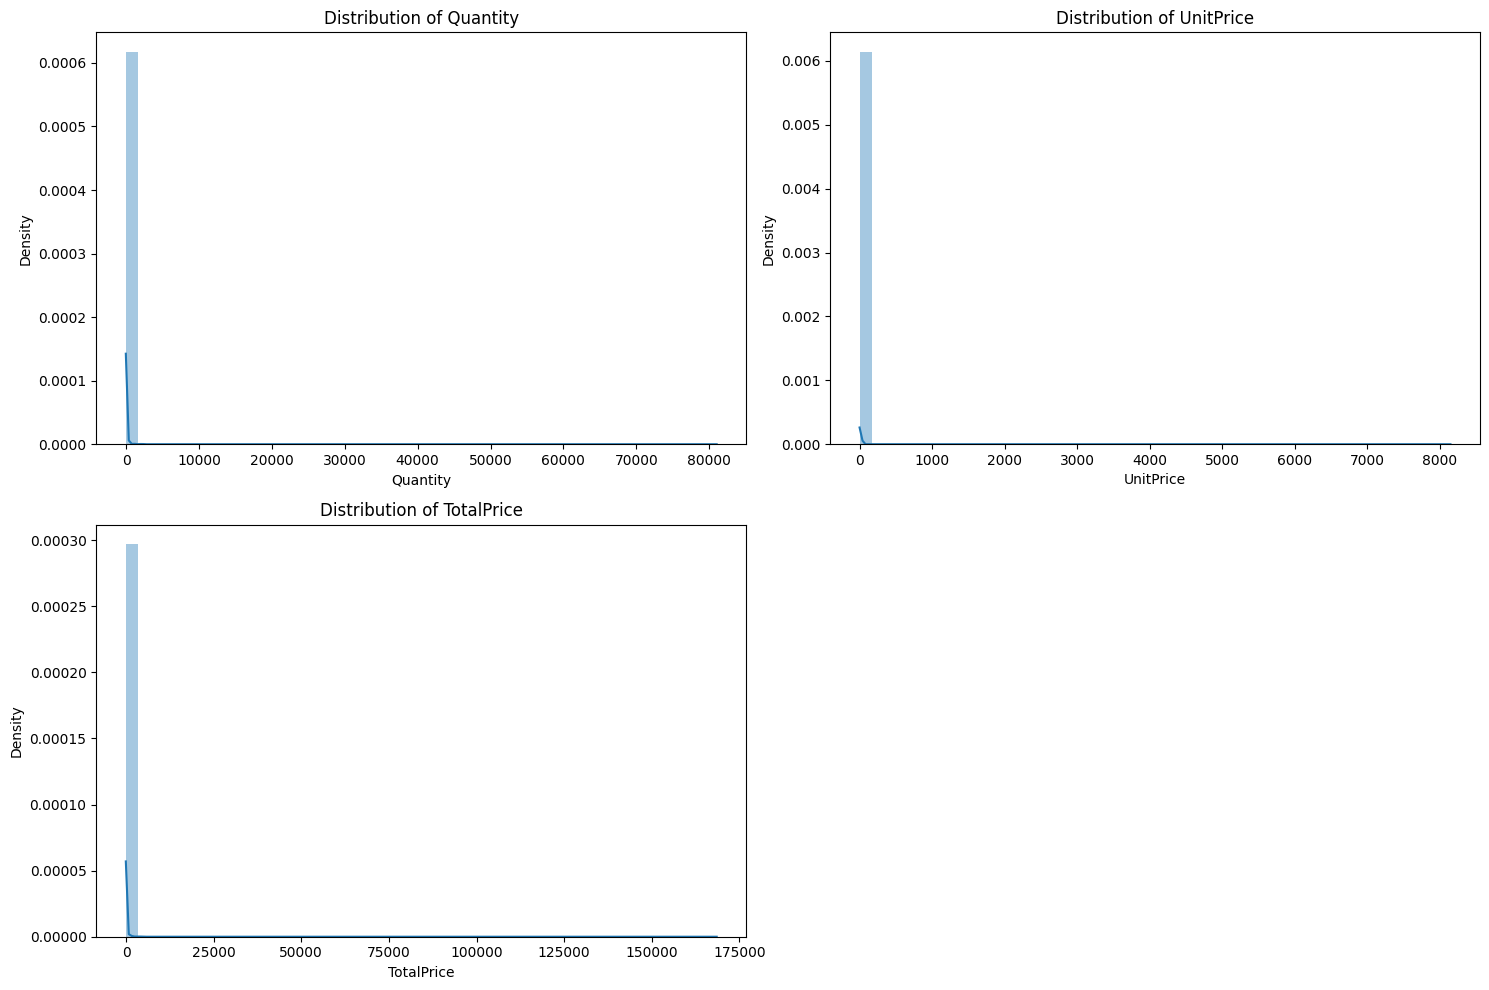

In [15]:
plt.figure(figsize=(15,10))


plt.subplot(2,2,1)
sns.distplot(df['Quantity'],bins=50,kde=True)
plt.title('Distribution of Quantity')


plt.subplot(2,2,2)
sns.distplot(df['UnitPrice'],bins=50,kde=True)
plt.title('Distribution of UnitPrice')


plt.subplot(2,2,3)
sns.distplot(df['TotalPrice'],bins=50,kde=True)
plt.title('Distribution of TotalPrice')


plt.tight_layout()
plt.show()


Here we can see that its a Positively skewed (or right-skewed) distribution with outliers (high quantities). It is a type of distribution in which most values are clustered around the left tail of the distribution


**2. Boxplots for Outlier Detection**

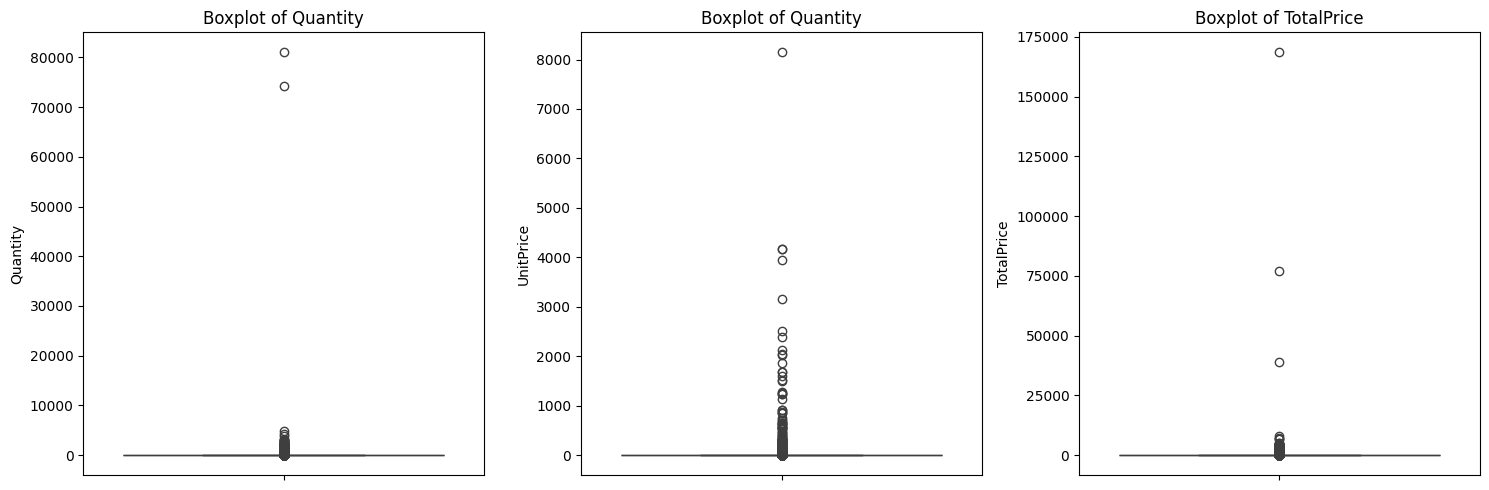

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(y=df['Quantity'])
plt.title('Boxplot of Quantity')

plt.subplot(1,3,2)
sns.boxplot(y=df['UnitPrice'])
plt.title('Boxplot of Quantity')

plt.subplot(1,3,3)
sns.boxplot(y=df['TotalPrice'])
plt.title('Boxplot of TotalPrice')

plt.tight_layout()
plt.show()

**3. Transforming skewed distribution to symmetrical distribution**

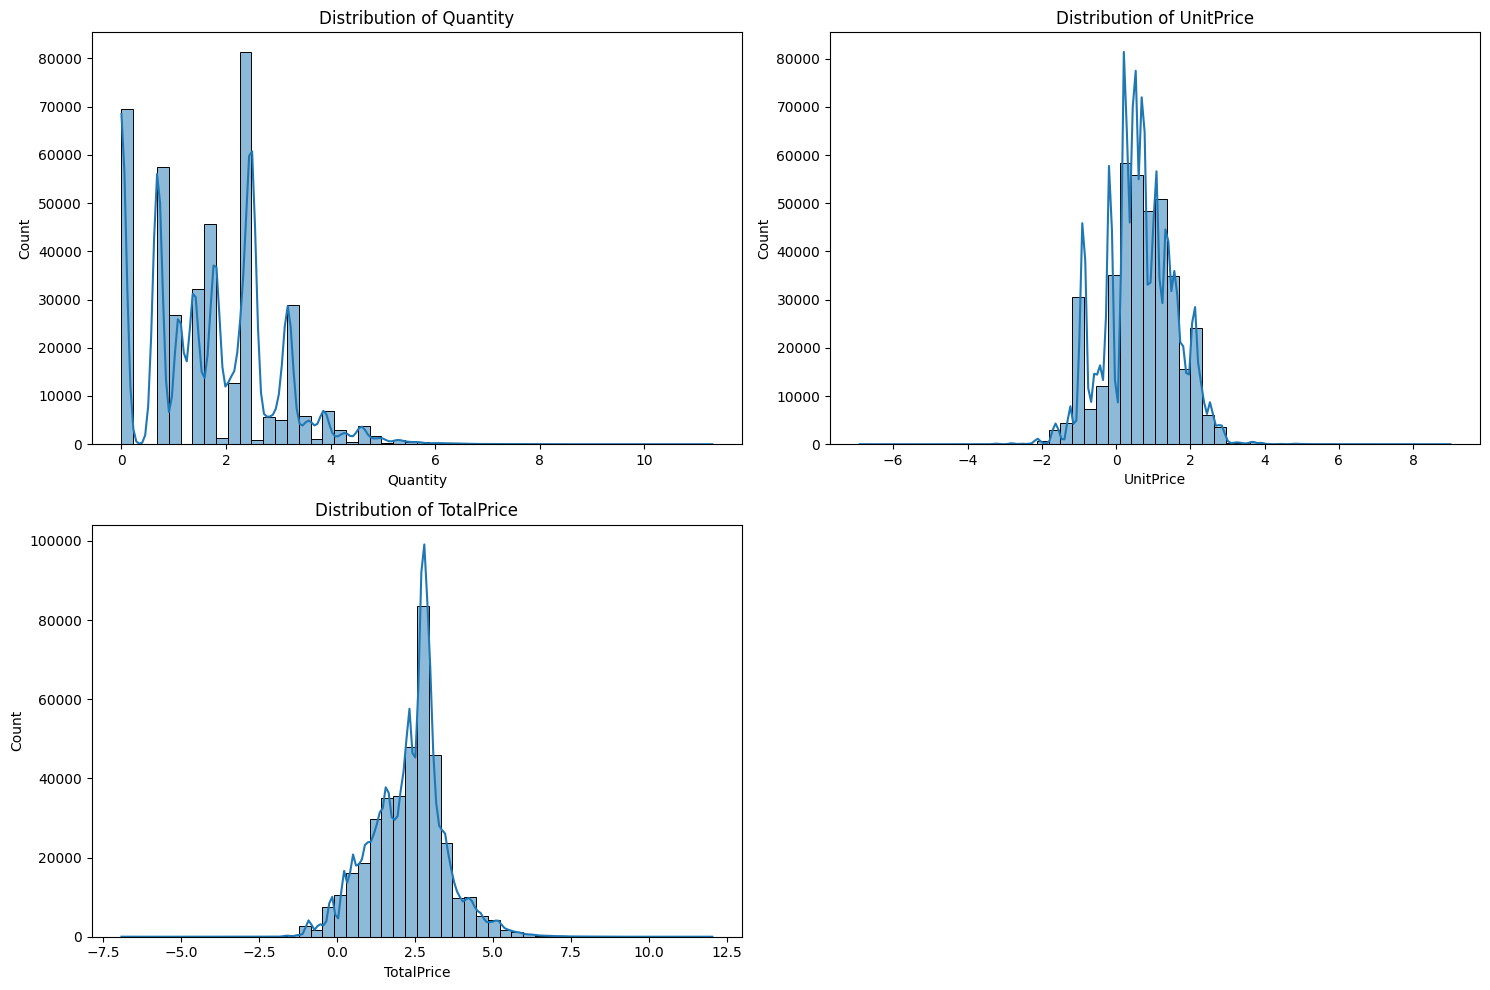

In [17]:
plt.figure(figsize=(15,10))


plt.subplot(2,2,1)
sns.histplot(np.log(df['Quantity']),bins=50,kde=True)
plt.title('Distribution of Quantity')


plt.subplot(2,2,2)
sns.histplot(np.log(df['UnitPrice']),bins=50,kde=True)
plt.title('Distribution of UnitPrice')


plt.subplot(2,2,3)
sns.histplot(np.log(df['TotalPrice']),bins=50,kde=True)
plt.title('Distribution of TotalPrice')


plt.tight_layout()
plt.show()


**4. Categorical Analysis - Top Countries**

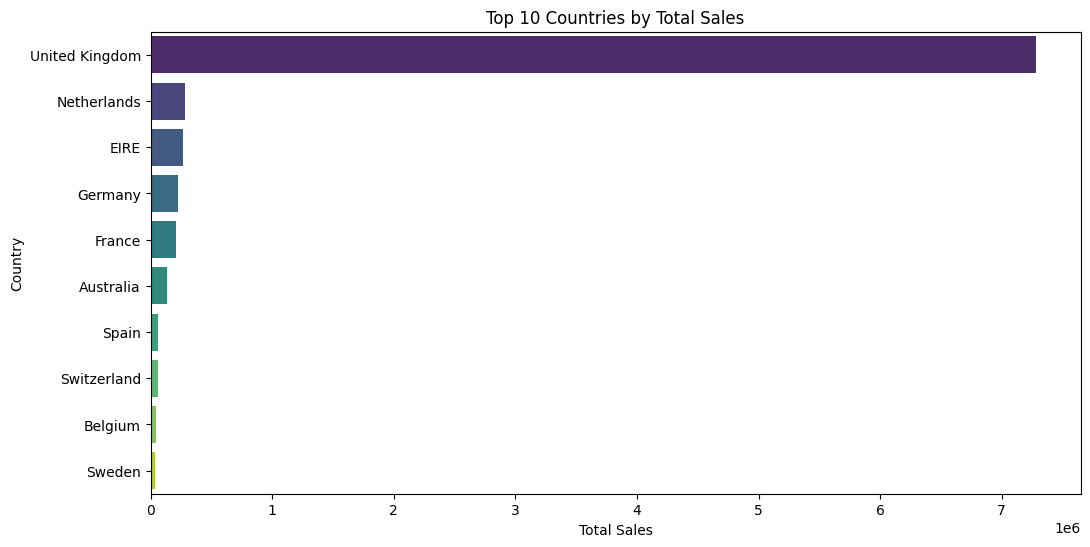

In [18]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=country_sales.values,y=country_sales.index,palette='viridis')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales')
plt.show()

From this graph we can see that most of the customers are from United Kingdom that make sense as company is from UK bases after that we have Netherlands, Germany ,France ,EIRE and Spain

**5. Top Products**

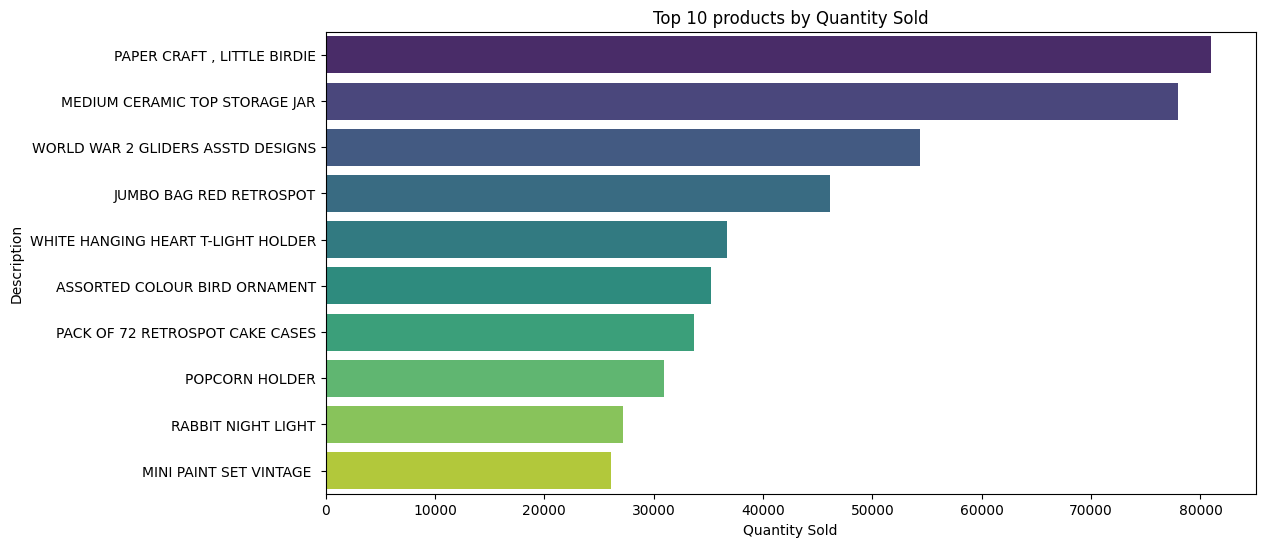

In [19]:
product_sales = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=product_sales.values,y=product_sales.index,palette='viridis')
plt.title('Top 10 products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.show()

UK dominates sales (`80-90%). Popular products like 'MEDIUM CERAMIC TOP STORAGE JAR'.

**6. Time-Based Analysis**

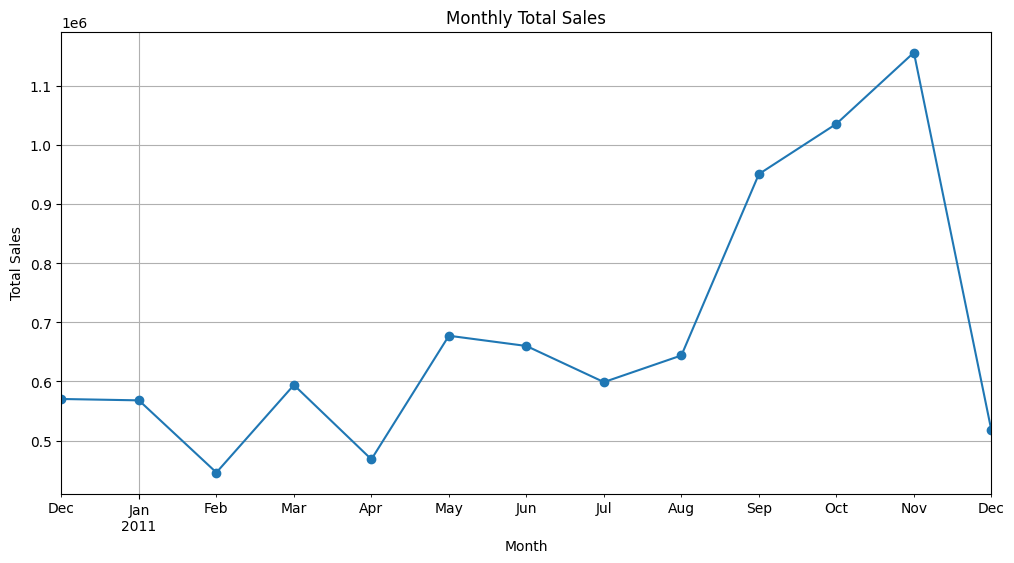

In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line',marker='o')
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

Sales peak in Q4 (holidays), data spans 2010-2011.

 Most numbers of customers have purchased the gifts in the month of November, October and December.As we all know they have festive season in end of the year as well new year to celebrate so we have highest numbers of transaction in november, october, december as company have most of the customer wholesales who are keeping stocks for festive season.

**7. Correlation Analysis**

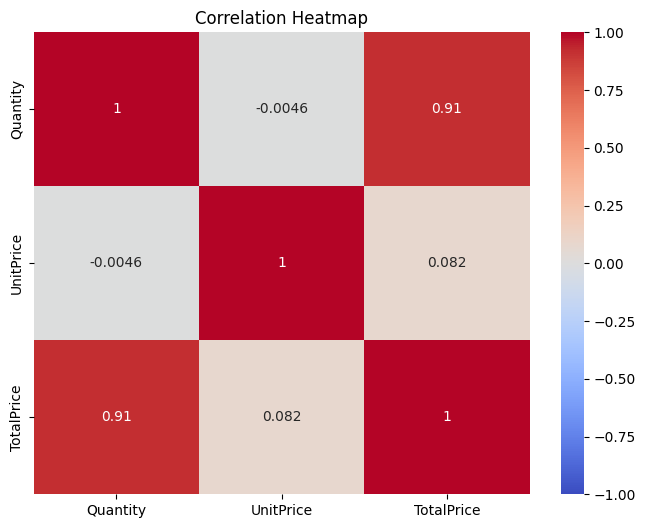

In [21]:
numerical_df = df[['Quantity','UnitPrice','TotalPrice']]
corr = numerical_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

Quantity and TotalPrice highly correlated (obvious), UnitPrice weakly negative with Quantity

**8. Sales Presentation with respect to days and hours**

In [22]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")

In [23]:
df['Day']=df['InvoiceDate'].dt.day_name()
df['Hour']=df['InvoiceDate'].dt.hour

In [24]:
day_df=df['Day'].value_counts().reset_index()
day_df

,Day,count
0,Thursday,79243
1,Wednesday,68040
2,Tuesday,65744
3,Monday,64231
4,Sunday,61212
5,Friday,54222


<Axes: title={'center': 'Day wise transaction'}, xlabel='Day', ylabel='count'>

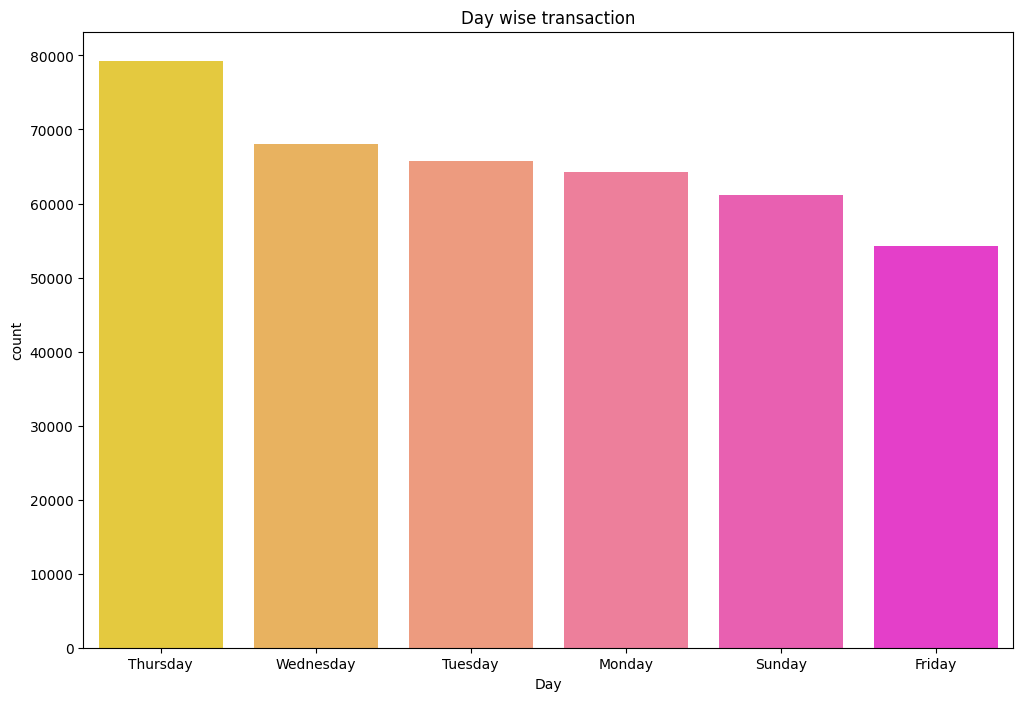

In [25]:
plt.figure(figsize=(12,8))
plt.title('Day wise transaction')
sns.barplot(x='Day',y='count',data=day_df, palette='spring_r')

Most of the customers have purchased the items in Thursday ,Wednesday and Tuesday.

In [26]:
hour_df=df['Hour'].value_counts().reset_index()

hour_df

,Hour,count
0,12,70938
1,13,63019
2,14,53251
3,11,48365
4,15,44790
5,10,37773
6,16,23715
7,9,21927
8,17,12941
9,8,8687


<Axes: title={'center': 'Hour wise transaction'}, xlabel='Hour', ylabel='count'>

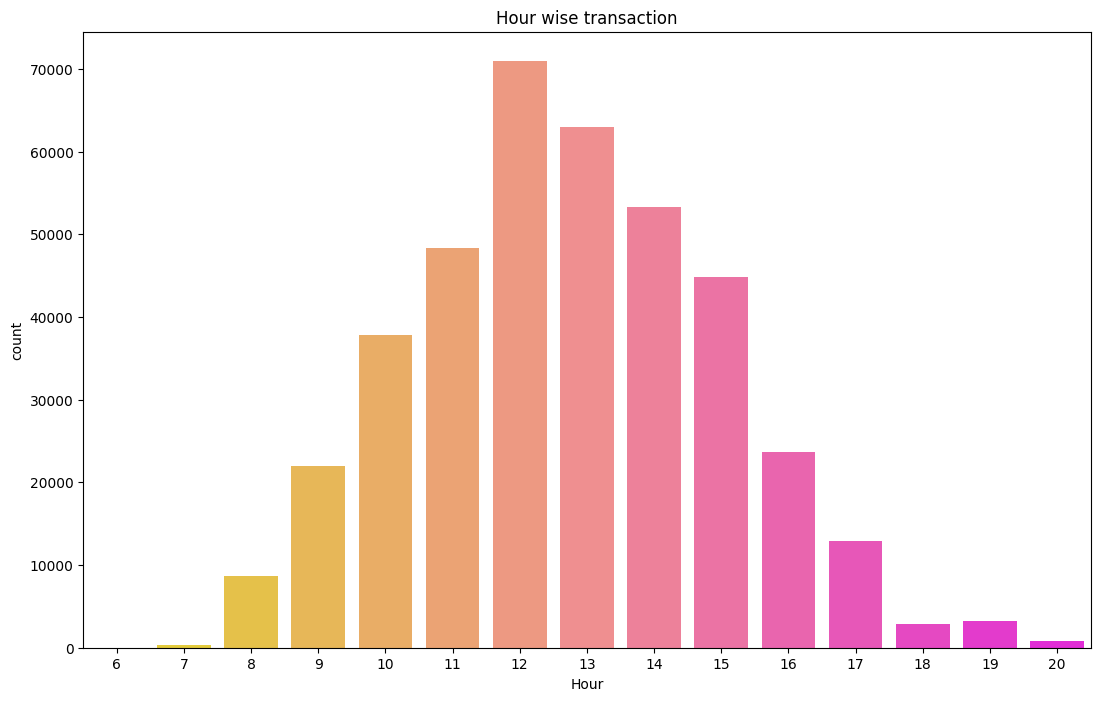

In [27]:
plt.figure(figsize=(13,8))
plt.title('Hour wise transaction')
sns.barplot(x='Hour',y='count',data=hour_df, palette='spring_r')

most numbers of purchasing is done between 12pm clock to 3pm.

**9. Shift-wise Sales in a Day**

In [28]:
#dividing hours into morning, afternoon and evening
def time_type(time):
  if(time>=6 and time<=11):
    return 'Morning'
  elif(time>=12 and time<=17):
    return 'Afternoon'
  else:
    return 'Evening'

<Axes: title={'center': 'Time_type wise transaction'}, xlabel='Time_type', ylabel='count'>

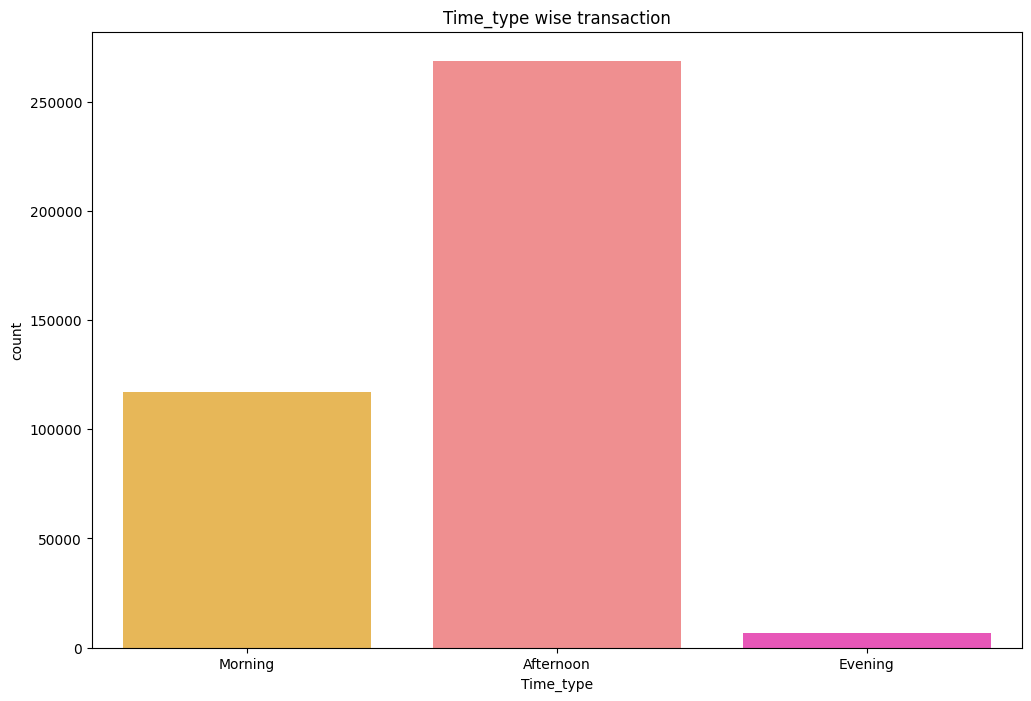

In [29]:
df['Time_type']=df['Hour'].apply(time_type)

plt.figure(figsize=(12,8))
plt.title('Time_type wise transaction')
sns.countplot(x='Time_type',data=df, palette='spring_r')

Most of the customers have purchased the items in Afternoon.

Moderate numbers of customers have purchased the items in Morning and least numbers of customers have purchased the items in Evening.To increasse transacction at evening we can do one thing provide the offers/discounts at evening

**10. Customer Distribution**

In [30]:
print("Unique Customers :", df['CustomerID'].nunique())

Unique Customers : 4338


In [31]:
print("Unique Invoices :", df['InvoiceNo'].nunique())

Unique Invoices : 18532


In [32]:
print("Unique Products :", df['StockCode'].nunique())

Unique Products : 3665


### Feature Engineering (RFM Analysis)

In [33]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)  # Find the reference date (day after the last invoice)


In [34]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (ref_date - x.max()).days, # Recency
    'InvoiceNo' : 'nunique', # Frequency (unique invoices)
    'TotalPrice' : 'sum' # Monetary
}).rename(columns={
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'TotalPrice' : 'Monetary'
})

In [35]:
rfm = rfm[rfm['Monetary']>0]  # Handle any zero Monetary

In [36]:
rfm.reset_index()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
...,...,...,...,...
4333,18280,278,1,180.60
4334,18281,181,1,80.82
4335,18282,8,2,178.05
4336,18283,4,16,2045.53


In [37]:
rfm.Recency.describe()

count    4338.000000
mean       92.536422
std       100.014169
min         1.000000
25%        18.000000
50%        51.000000
75%       142.000000
max       374.000000
Name: Recency, dtype: float64

<Axes: xlabel='Recency', ylabel='Density'>

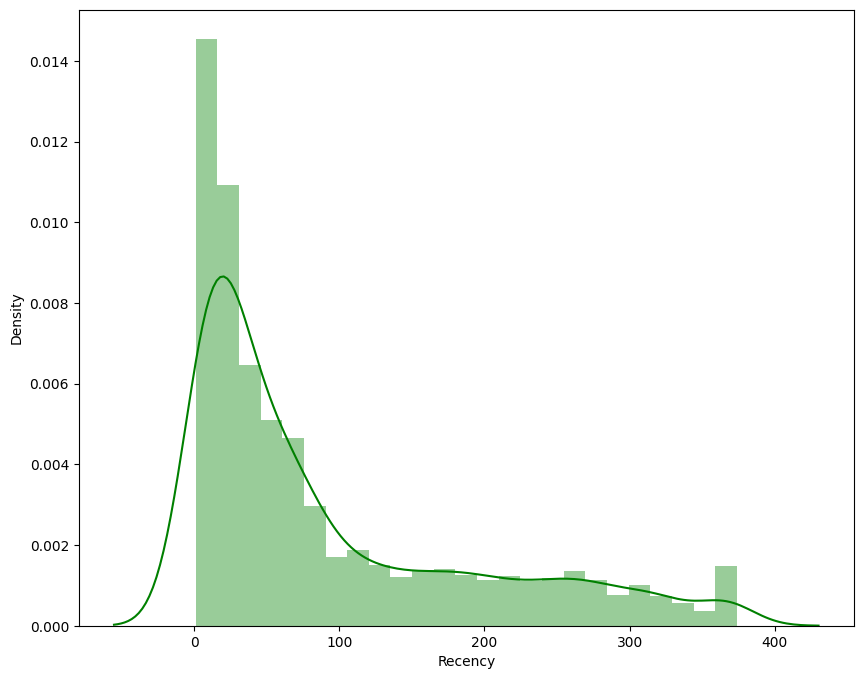

In [38]:
x = rfm['Recency']
plt.figure(figsize=(10,8))
sns.distplot(x,color='g')

In [39]:
rfm.Frequency.describe()

count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
Name: Frequency, dtype: float64

<Axes: xlabel='Frequency', ylabel='Density'>

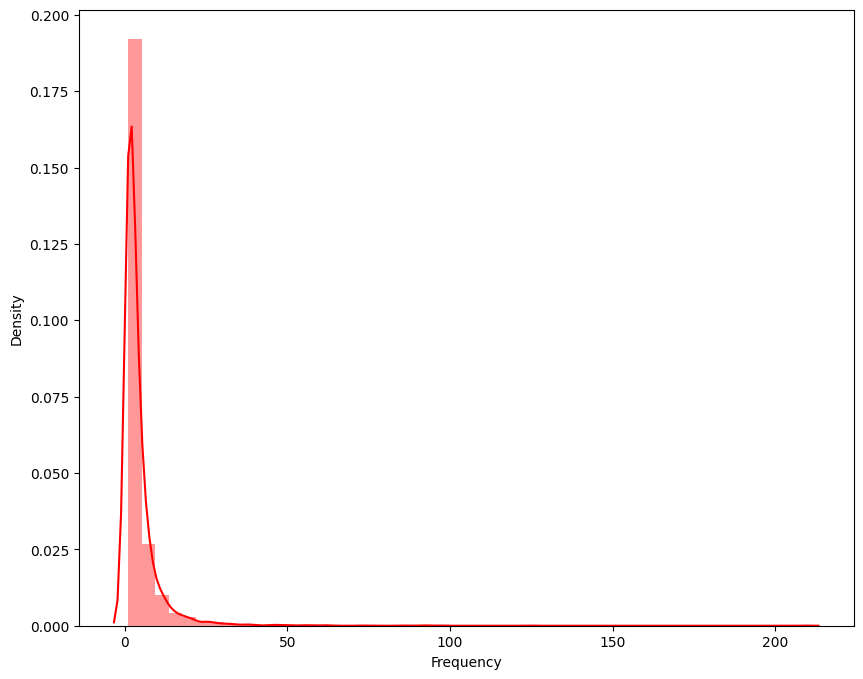

In [40]:
x = rfm['Frequency']
plt.figure(figsize=(10,8))
sns.distplot(x,color='r')

In [41]:
rfm.Monetary.describe()

count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: Monetary, dtype: float64

<Axes: xlabel='Monetary', ylabel='Density'>

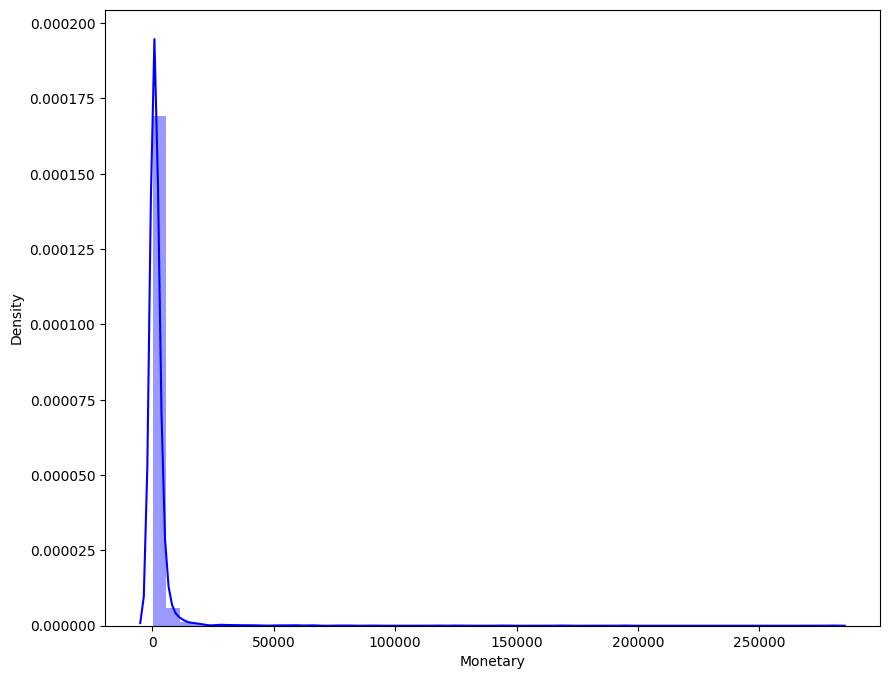

In [42]:
x = rfm['Monetary']
plt.figure(figsize=(10,8))
sns.distplot(x,color='b')

 Recency,Frequency and Monetary we can say that all are positively skewed distribution.

In [43]:
# Log-transform skewed features for Recency, Frequency, and Monetary

rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

<Axes: xlabel='Recency_log', ylabel='Density'>

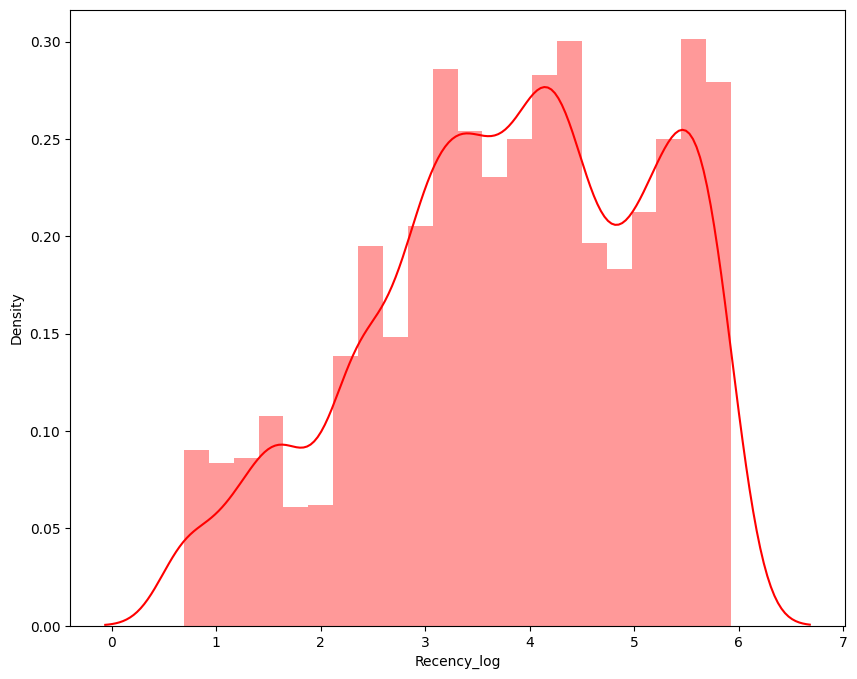

In [44]:
#Data distribution after data normalization for Recency
x = rfm['Recency_log']
plt.figure(figsize=(10,8))
sns.distplot(x,color='r')

<Axes: xlabel='Frequency_log', ylabel='Density'>

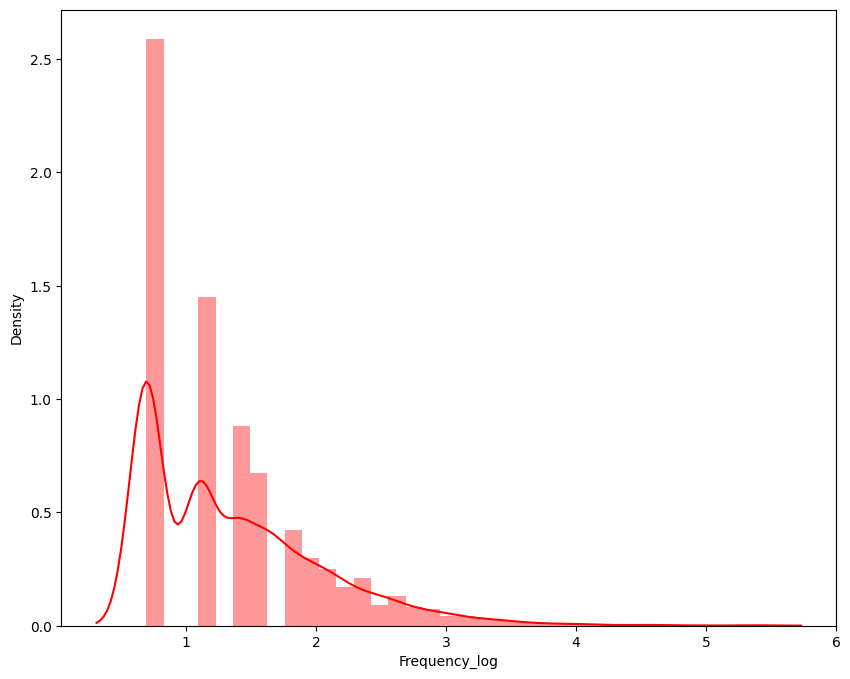

In [45]:
#Data distribution after data normalization for Frequency
x = rfm['Frequency_log']
plt.figure(figsize=(10,8))
sns.distplot(x,color='r')

<Axes: xlabel='Monetary_log', ylabel='Density'>

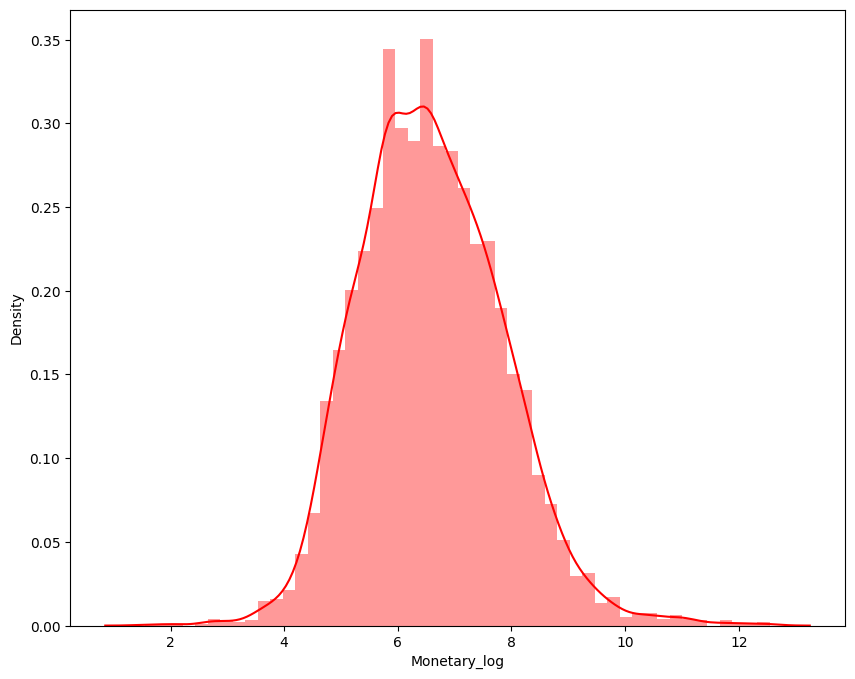

In [46]:
#Data distribution after data normalization for Monetary
x = rfm['Monetary_log']
plt.figure(figsize=(10,8))
sns.distplot(x,color='r')

In [47]:
rfm.head()

,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
CustomerID,,,,,,
12346,326,1,77183.60,5.789960,0.693147,11.253955
12347,2,7,4310.00,1.098612,2.079442,8.368925
12348,75,4,1797.24,4.330733,1.609438,7.494564
12349,19,1,1757.55,2.995732,0.693147,7.472245
12350,310,1,334.40,5.739793,0.693147,5.815324


In [48]:
rfm.describe()

,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081,3.830734,1.345582,6.588562
std,100.014169,7.697998,8985.230220,1.340261,0.683104,1.258438
min,1.000000,1.000000,3.750000,0.693147,0.693147,1.558145
25%,18.000000,1.000000,306.482500,2.944439,0.693147,5.728418
50%,51.000000,2.000000,668.570000,3.951244,1.098612,6.506636
75%,142.000000,5.000000,1660.597500,4.962845,1.791759,7.415535
max,374.000000,209.000000,280206.020000,5.926926,5.347108,12.543284


**Hence final features : Recency_log, Frequency_log, Monetary_log**

In [49]:
features = rfm[['Recency_log','Frequency_log','Monetary_log']]

### Data Scaling

Scale features for distance-based clustering.

In [50]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [51]:
# Convert back to DataFrame for ease

features_scaled_df = pd.DataFrame(features_scaled,columns=features.columns,index=features.index)
features_scaled_df.head()

,Recency_log,Frequency_log,Monetary_log
CustomerID,,,
12346,1.461993,-0.955214,3.707716
12347,-2.038734,1.074425,1.414903
12348,0.373104,0.386304,0.720024
12349,-0.623086,-0.955214,0.702287
12350,1.424558,-0.955214,-0.614514


### Model 1 - K-Means Clustering

Elbow Curve for optimal K

In [87]:
sse = []

k_range = range(1,20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

In [88]:
sse

[13013.999999999996,
 6483.702440065323,
 4869.681157060148,
 3939.4031759125537,
 3320.3109707169774,
 2856.5082134095733,
 2588.2319946082607,
 2348.9924086619876,
 2156.1315991767515,
 2012.1169622492703,
 1880.4790167569474,
 1771.3723267328019,
 1674.8682603598977,
 1594.1136887730213,
 1527.913775019718,
 1456.7069368144582,
 1407.11400354643,
 1352.5741930793674,
 1318.9050268812853]

Plot Elbow Curve

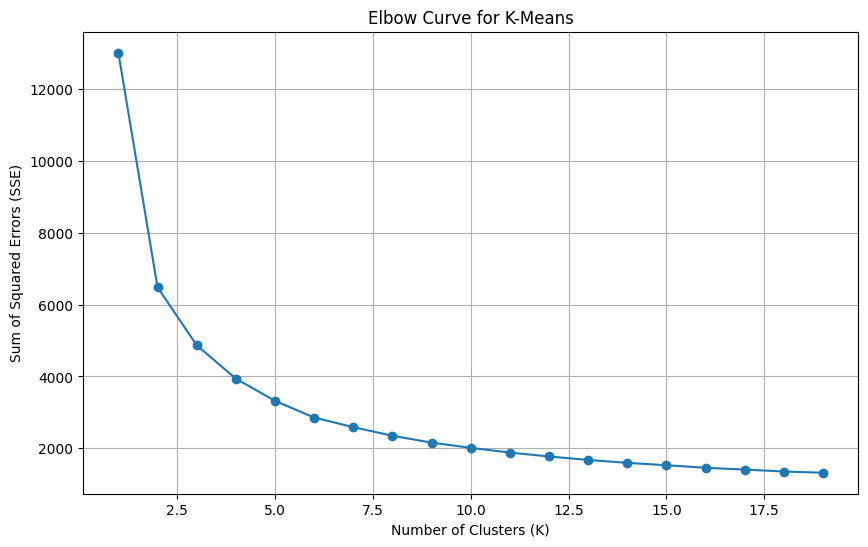

In [89]:
plt.figure(figsize=(10,6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Curve for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

**2 clusters are performing best. Hence, 2 clusters will be selected to build the KMeans model and classify the customers.**

In [90]:
# Assume optimal K from elbow 
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['KMeans_cluster'] = kmeans.fit_predict(features_scaled)

In [91]:
# Silhouette score
kmeans_sil = silhouette_score(features_scaled,rfm['KMeans_cluster'])
print(f"\nK-Means Silhouette Score : {kmeans_sil :.4f}")


K-Means Silhouette Score : 0.4330


**From the silhouette analysis, it is clearly understood that, 2 clusters are performing best. Hence, 2 clusters will be selected to build the KMeans model and classify the customers**

## Model 2 - Hierarchical (Agglomerative) Clustering

In [59]:
# Linkage matrix for dendrogram
linked = linkage(features_scaled, method='ward')

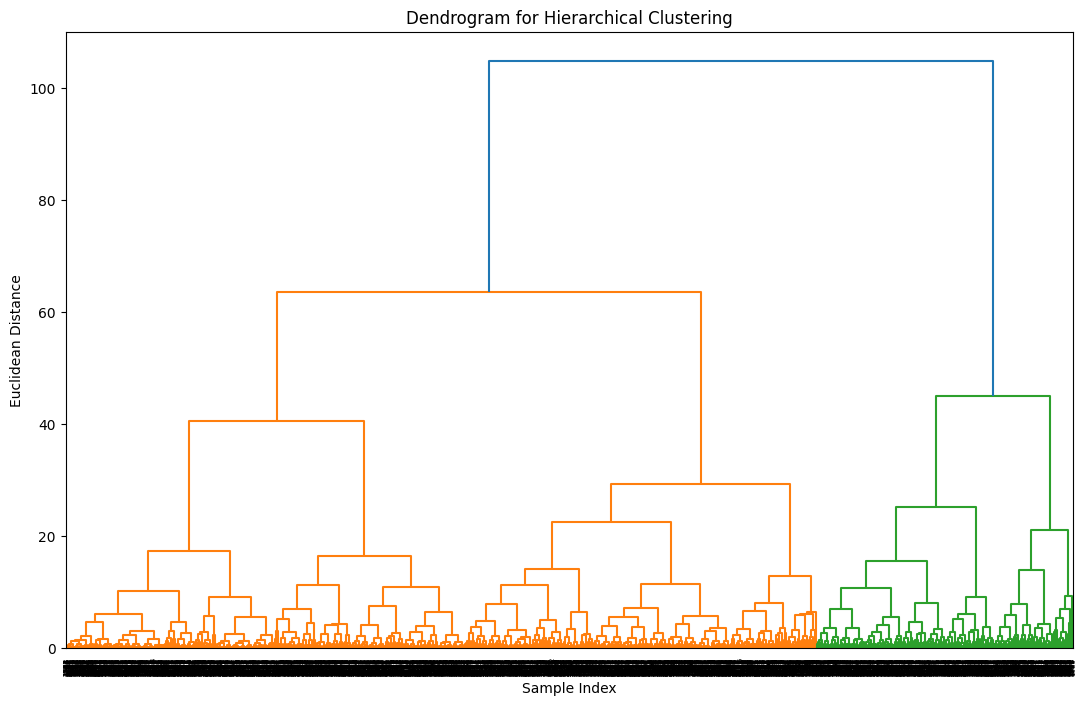

In [60]:
# Plot Dendrogram
plt.figure(figsize=(13,8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

**we can see No. of Clusters = 2**

In [61]:
# Assume clusters from dendrogram (cut where the dendrogram branches have the longest vertical distances)
n_clusters_hier = 2
hier = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
rfm['Hier_Cluster'] = hier.fit_predict(features_scaled)

In [62]:
# Silhouette score
hier_sil = silhouette_score(features_scaled, rfm['Hier_Cluster'])
print(f"\nHierarchical Silhouette Score : {hier_sil:.4f}")


Hierarchical Silhouette Score : 0.4040


**2 clusters are performing best. Hence, 2 clusters will be selected to build the Hierearchical Clustering model and classify the customers.**

### Model 3 - DBSCAN

In [63]:
# Find optimal eps : Sort k-distances (k=min_samples)
from sklearn.neighbors import NearestNeighbors
min_samples = 15  # Common starting point
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(features_scaled)
distances, indices = nn.kneighbors(features_scaled)
k_dist = np.sort(distances[:,min_samples-1])

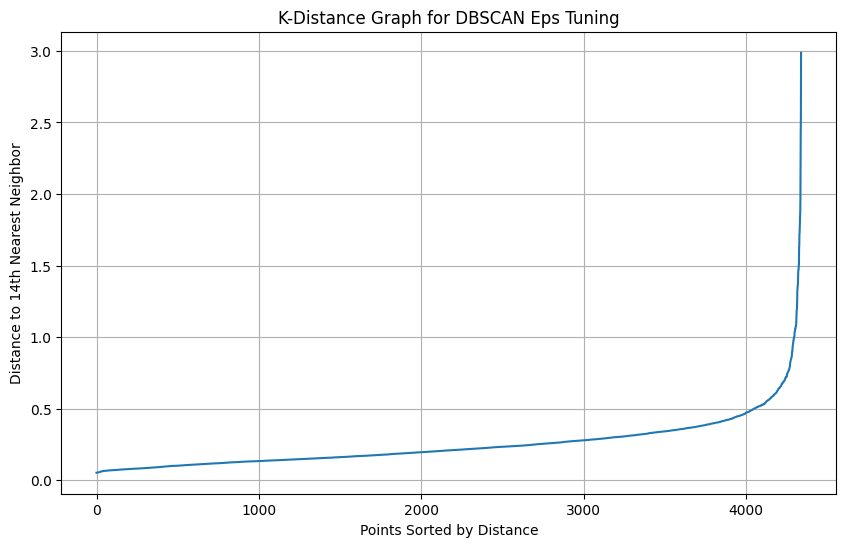

In [64]:
# Plot k-distances graph for eps (elbow in this curve)
plt.figure(figsize=(10,6))
plt.plot(k_dist)
plt.title('K-Distance Graph for DBSCAN Eps Tuning')
plt.xlabel('Points Sorted by Distance')
plt.ylabel(f'Distance to {min_samples-1}th Nearest Neighbor')
plt.grid(True)
plt.show()

In [65]:
# Getting eps from knee
eps = 0.5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(features_scaled)

In [66]:
# Remove noise for silhouette (if any)
valid_clusters = rfm['DBSCAN_Cluster'] != -1

In [67]:
valid_clusters


CustomerID
12346    False
12347     True
12348     True
12349    False
12350     True
         ...  
18280     True
18281     True
18282     True
18283     True
18287     True
Name: DBSCAN_Cluster, Length: 4338, dtype: bool

In [68]:
dbscan_sil = silhouette_score(features_scaled[valid_clusters],rfm['DBSCAN_Cluster'][valid_clusters]) if np.sum(valid_clusters) > 1 else 0

In [69]:
print(f"\nDBSCAN Silhouette Score (excluding noise) : {dbscan_sil : .4f}")


DBSCAN Silhouette Score (excluding noise) :  0.2961


In [70]:
print(f"Number of Noise Points : {sum(rfm['DBSCAN_Cluster']== -1)}")

Number of Noise Points : 106


### Visualize Clusters (For All Models)

In [71]:
# PCA for 2D visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [72]:
# Add to DataFrame
rfm['PCA1'] = features_pca[:,0]
rfm['PCA2'] =features_pca[:,1]

**Plot for each model**

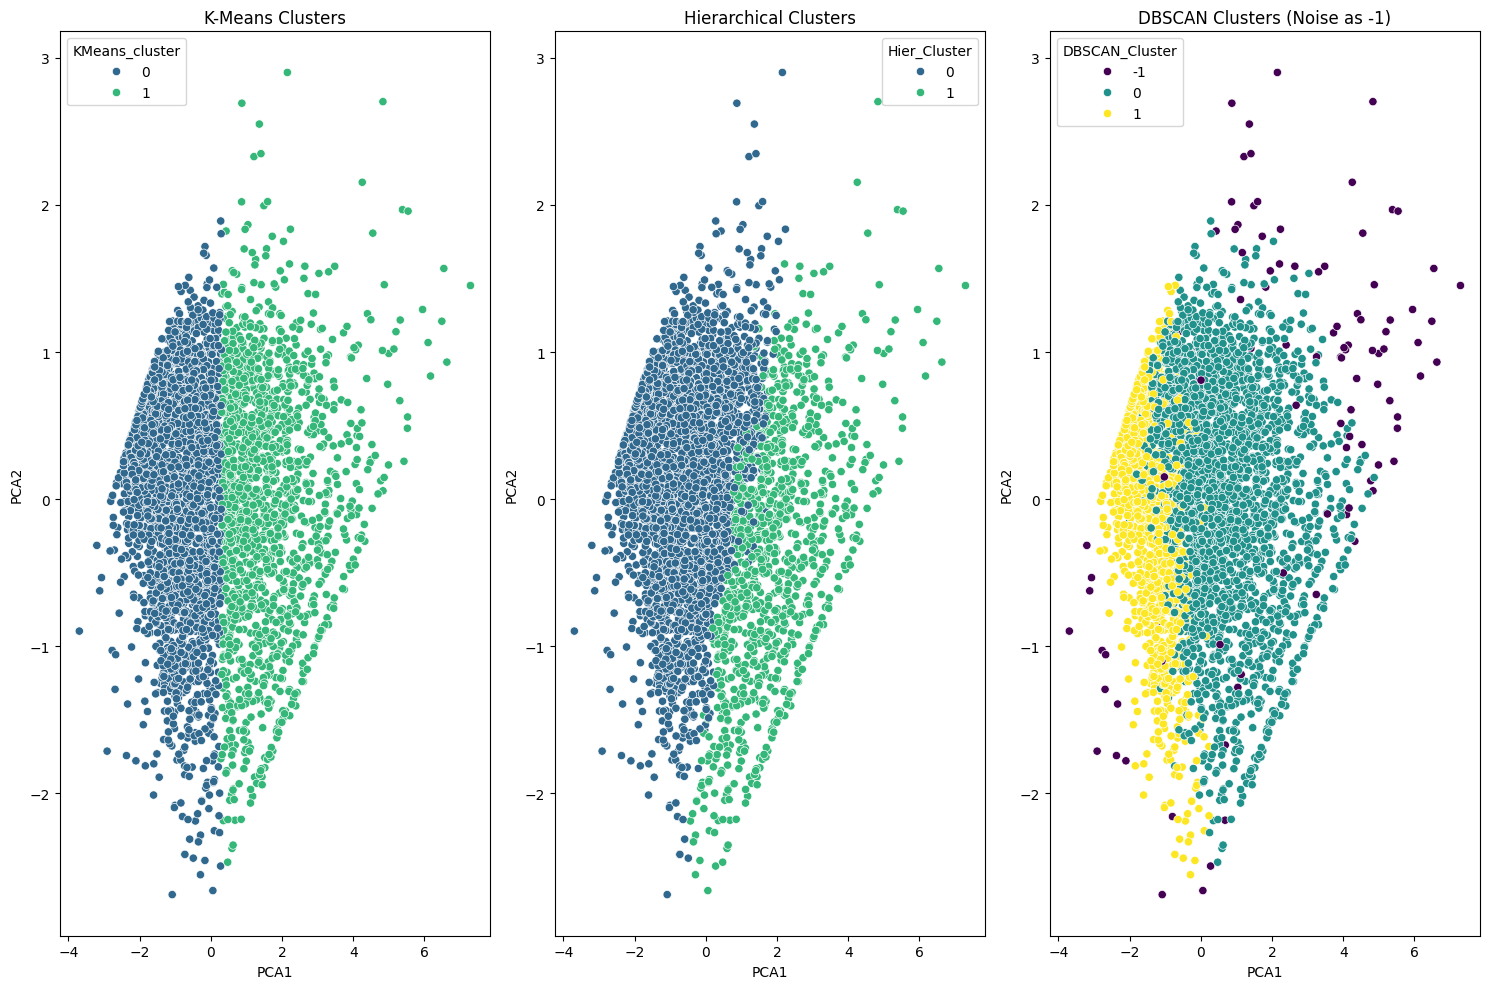

In [73]:
fig, axs = plt.subplots(1,3, figsize=(15,10))

#K-Means
sns.scatterplot(data=rfm,x='PCA1',y='PCA2', hue='KMeans_cluster',palette='viridis',ax=axs[0])
axs[0].set_title('K-Means Clusters')

# Hierarchical
sns.scatterplot(data=rfm,x='PCA1',y='PCA2', hue='Hier_Cluster',palette='viridis',ax=axs[1])
axs[1].set_title('Hierarchical Clusters')

# DBSCAN
sns.scatterplot(data=rfm,x='PCA1',y='PCA2',hue='DBSCAN_Cluster',palette='viridis',ax=axs[2])
axs[2].set_title('DBSCAN Clusters (Noise as -1)')

plt.tight_layout()
plt.show()

### Visualize Cluster Centers on Pairwise Scatter Plots

In [74]:
# Define pairwise pairs
pairs = [
    ('Recency_log','Frequency_log'),
    ('Recency_log','Monetary_log'),
    ('Frequency_log','Monetary_log')
]

In [75]:
# Function to plot pairwise with centers
def plot_clusters_with_centers(model_name,cluster_col,centers_df):
    
    for x_col,y_col in pairs:
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=rfm,x=x_col,y=y_col,hue=cluster_col,palette='viridis')
        if model_name == 'DBSCAN':
            plt.scatter(centers_df[x_col],centers_df[y_col],marker='*',s=300,c='red',label='Centers') # Only plot centers for non-noise clusters
        else:
            plt.scatter(centers_df[x_col],centers_df[y_col],marker='*',s=300,c='red',label='Centers')
            plt.title(f'{model_name}: {x_col} vs {y_col}')
            plt.legend()
            plt.tight_layout()
            plt.show()

### K-Means Centers

In [ ]:
kmeans_centers_scaled = kmeans.cluster_centers_
kmeans_centers = scaler.inverse_transform(kmeans_centers_scaled)
kmeans_centers_df = pd.DataFrame(kmeans_centers,columns=features.columns)
print("\nK-Means Cluster Centers :")
kmeans_centers_df


K-Means Cluster Centers :


,Recency_log,Frequency_log,Monetary_log
0,4.501003,0.935678,5.879714
1,2.743066,2.010747,7.738834


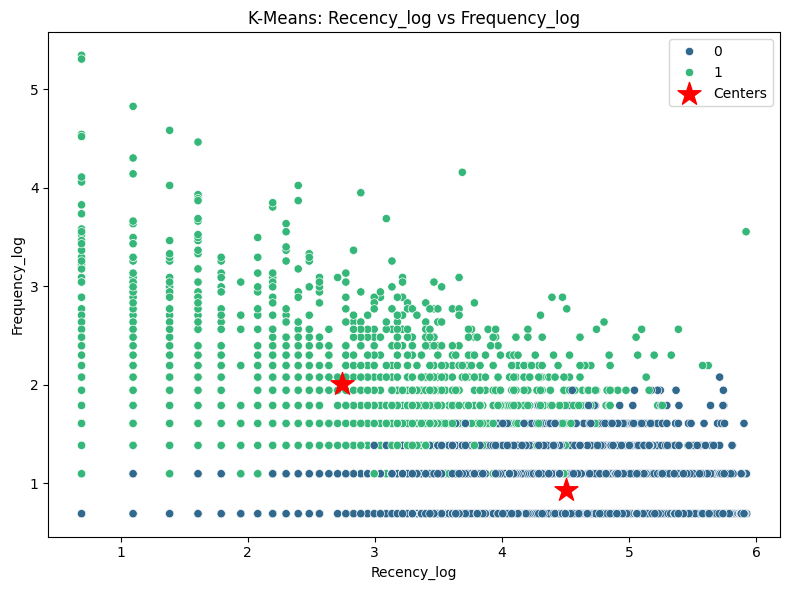

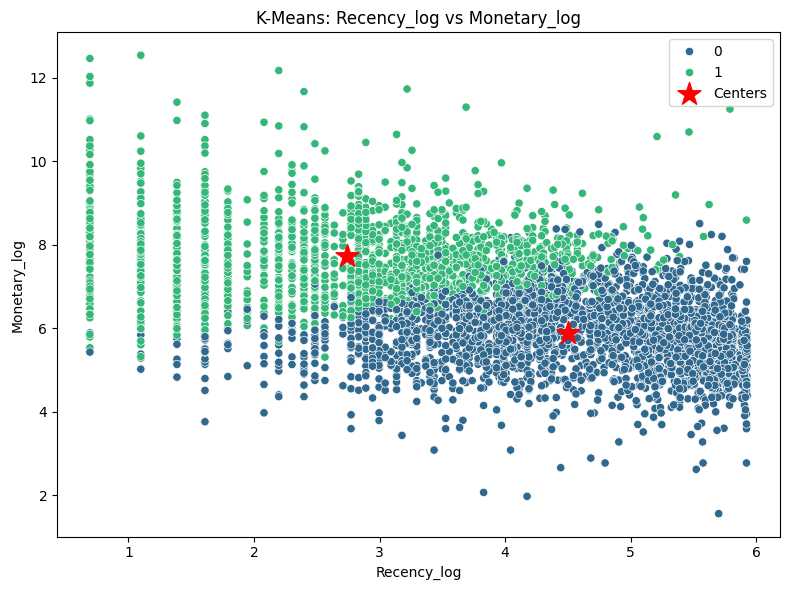

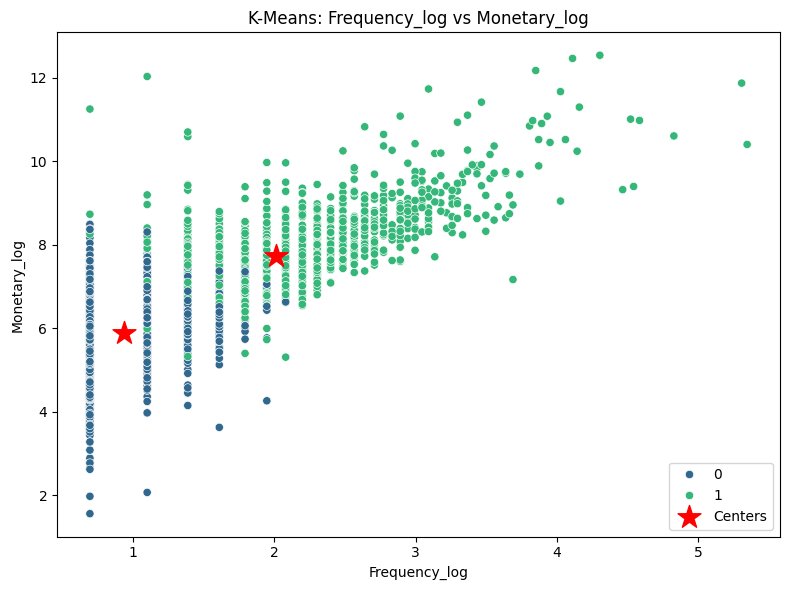

In [93]:
plot_clusters_with_centers('K-Means','KMeans_cluster',kmeans_centers_df)

**Customers are separated when we cluster them by Recency, Frequency and Monetary.**

### Hierarchical Centers (group means)

In [ ]:
hier_centers_df = rfm.groupby('Hier_Cluster')[features.columns].mean().reset_index(drop=True)
print("\nHierarchical Cluster Centers (Means) :")
hier_centers_df


Hierarchical Cluster Centers (Means) :


,Recency_log,Frequency_log,Monetary_log
0,4.404840,1.082362,6.188953
1,2.151018,2.115711,7.757735


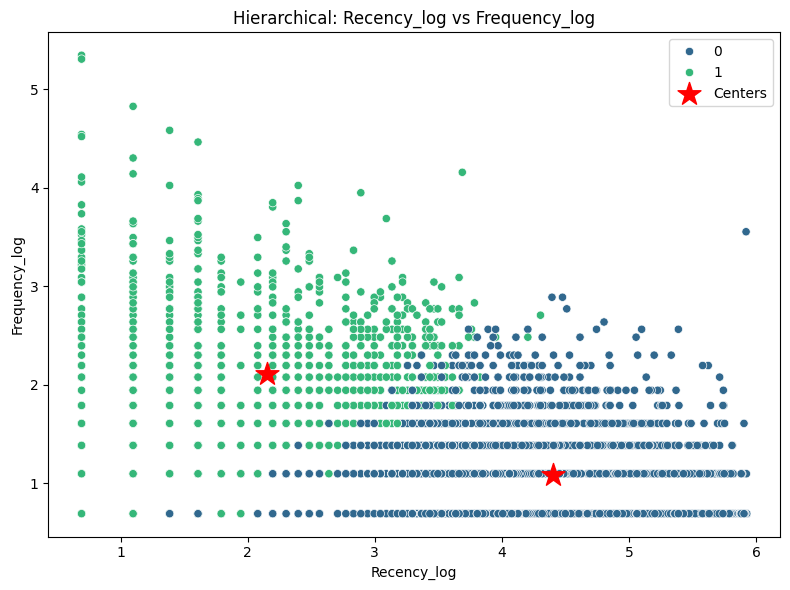

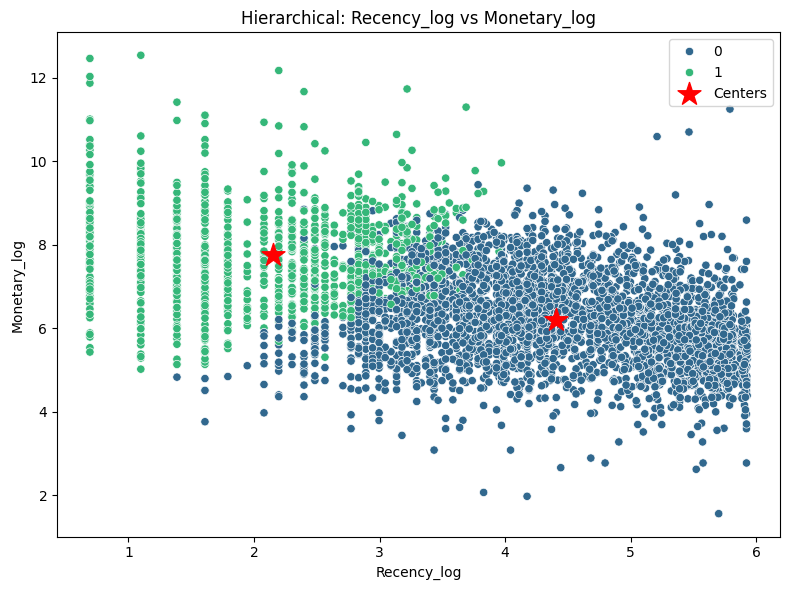

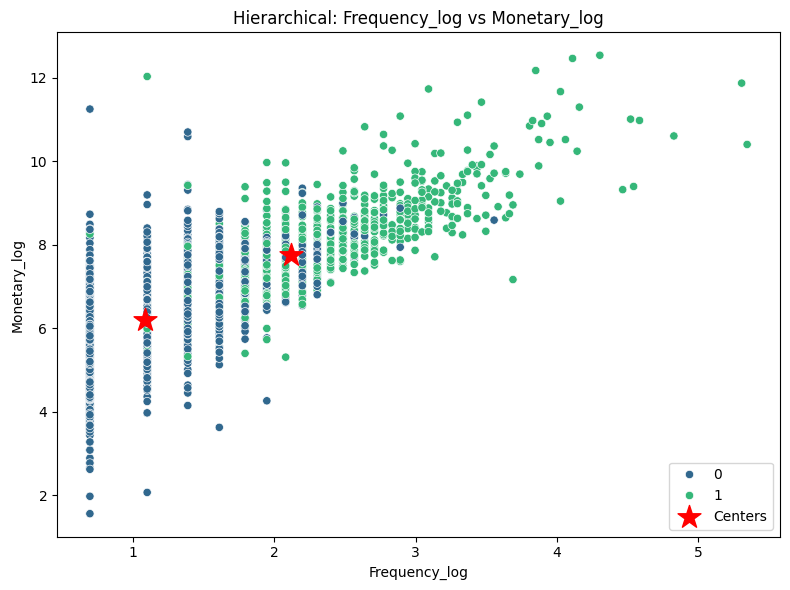

In [79]:
plot_clusters_with_centers('Hierarchical','Hier_Cluster',hier_centers_df)

**The customer belongs to cluster 1 are premium customers and we can keep them in comapny's loyalty program and for the customer belongs to cluster 0 we can provide them offer or create some strategies for them so that they will do more transaction with us.**

### DBSCAN Centers (group means, excluding noise)

In [ ]:

dbscan_valid = rfm[rfm['DBSCAN_Cluster']!= -1]
dbscan_centers_df = dbscan_valid.groupby('DBSCAN_Cluster')[features.columns].mean().reset_index(drop=True)
print("\nDBSCAN Cluster Centers (Means, excluding noise) :")
dbscan_centers_df


DBSCAN Cluster Centers (Means, excluding noise) :


,Recency_log,Frequency_log,Monetary_log
0,3.423590,1.649292,7.071526
1,4.661337,0.693147,5.546853


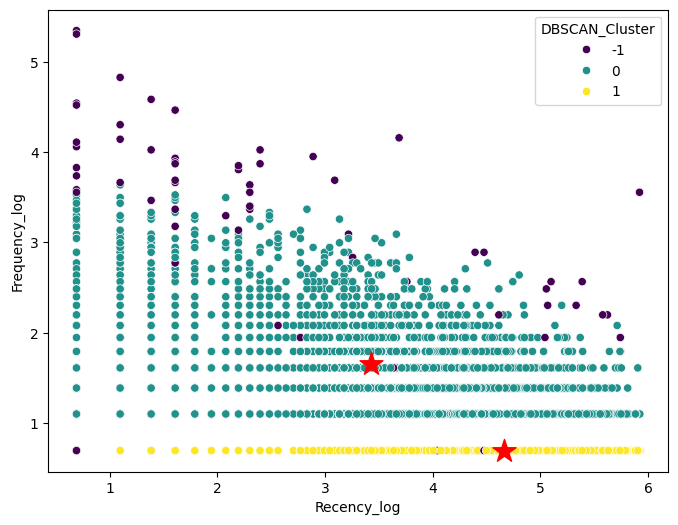

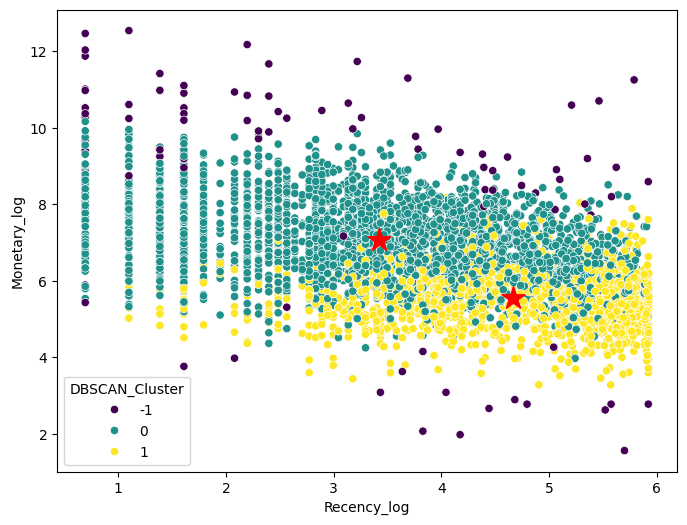

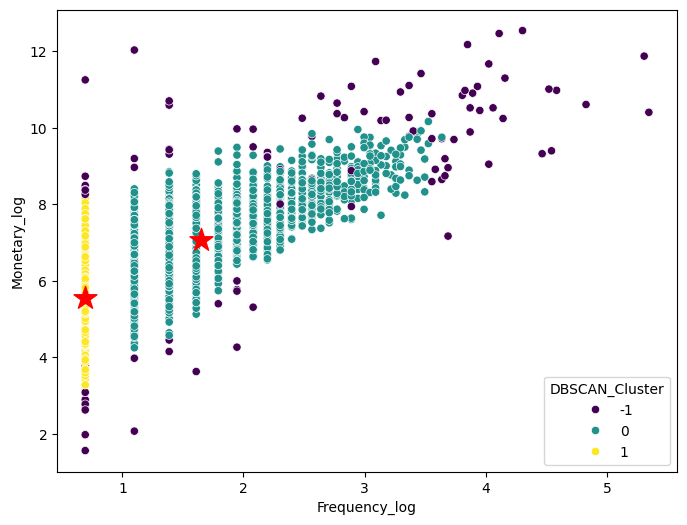

In [81]:
plot_clusters_with_centers('DBSCAN','DBSCAN_Cluster',dbscan_centers_df)

 **Customers are well separated when we cluster them by Recency, Frequency and Monetary and optimal number of cluster is equal to 3.**

### Interpret Clusters

In [82]:
cluster_summary = rfm.groupby('KMeans_cluster')[['Recency','Frequency','Monetary']].mean().reset_index()
print("\nCluster Summary (K-Means) :")
cluster_summary


Cluster Summary (K-Means) :


,KMeans_cluster,Recency,Frequency,Monetary
0,0,133.871173,1.674010,496.254643
1,1,25.853012,8.463253,4553.156001


In [85]:
cluster_summary = rfm.groupby('Hier_Cluster')[['Recency','Frequency','Monetary']].mean().reset_index()
print("\nCluster Summary (Hierarchical Clustering) :")
cluster_summary


Cluster Summary (Hierarchical Clustering) :


,Hier_Cluster,Recency,Frequency,Monetary
0,0,120.502011,2.293845,874.832720
1,1,10.714932,10.059729,5483.144534


In [86]:
cluster_summary = rfm.groupby('DBSCAN_Cluster')[['Recency','Frequency','Monetary']].mean().reset_index()
print("\nCluster Summary (DBSCAN) :")
cluster_summary


Cluster Summary (DBSCAN) :


,DBSCAN_Cluster,Recency,Frequency,Monetary
0,-1,62.028302,25.509434,29403.007736
1,0,59.168417,5.199928,1906.806155
2,1,157.365058,1.000000,343.846554


**Use K-Means for simplicity if clusters are even; DBSCAN if outliers expected; Hierarchical for small data/interpretability.**